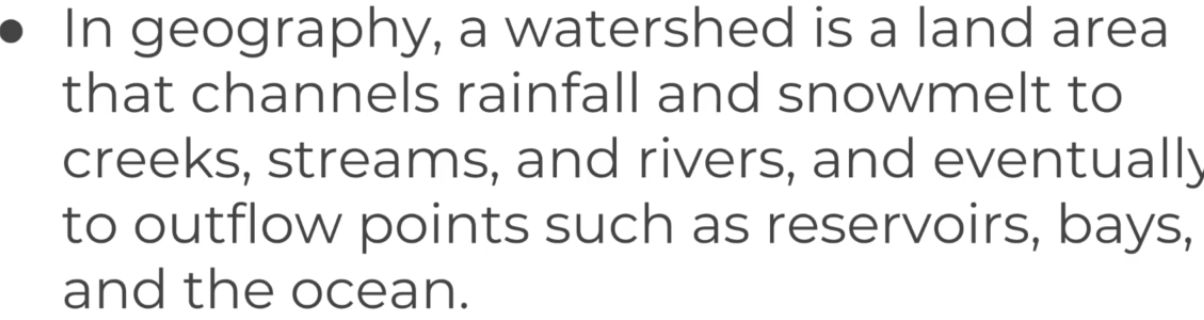

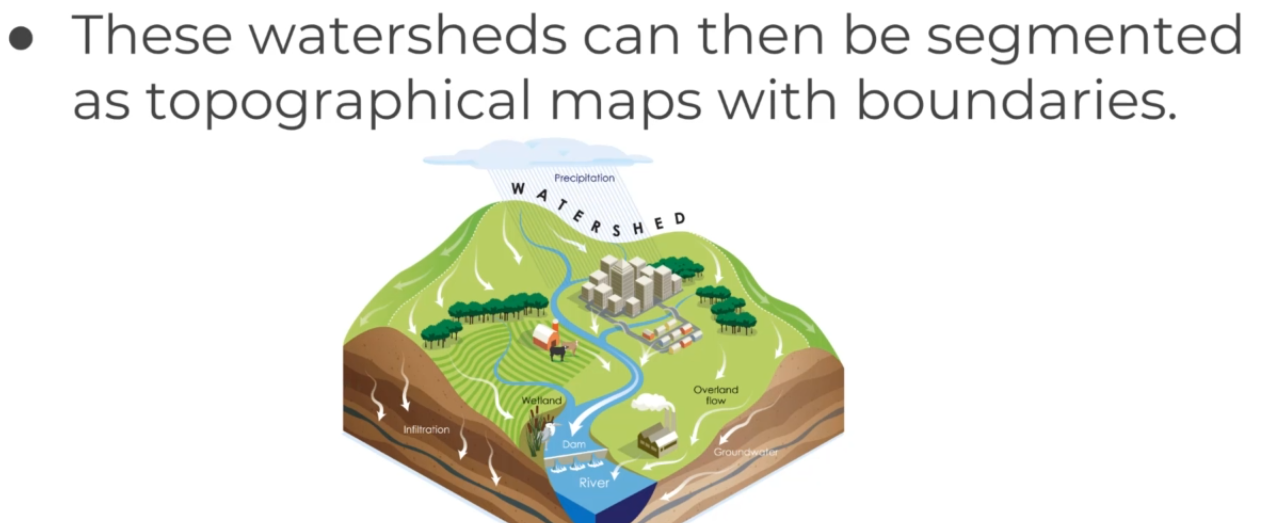

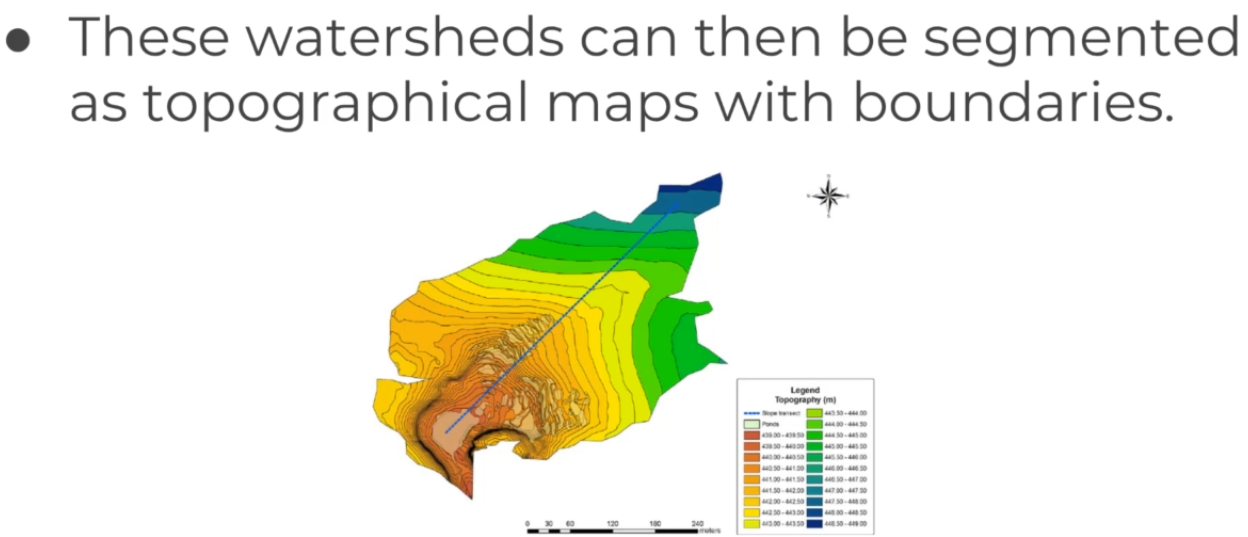

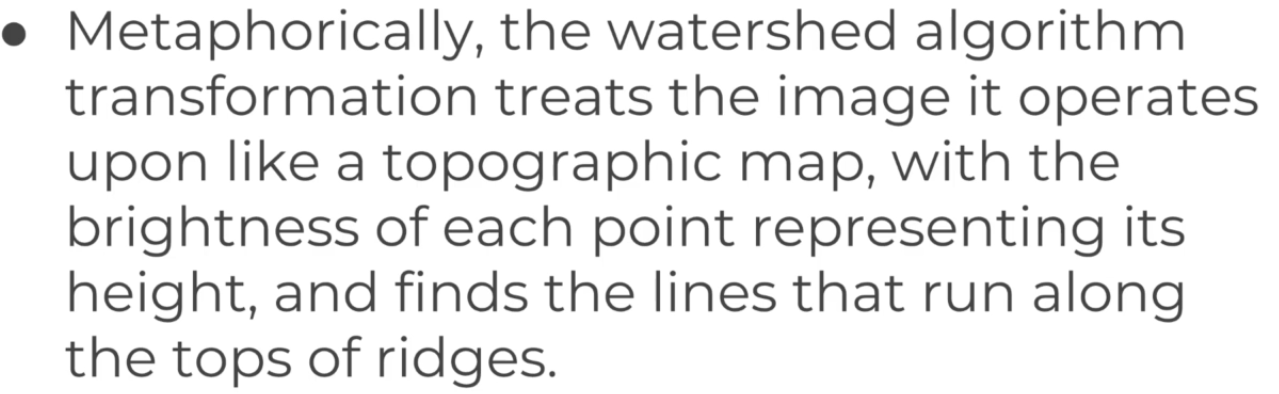

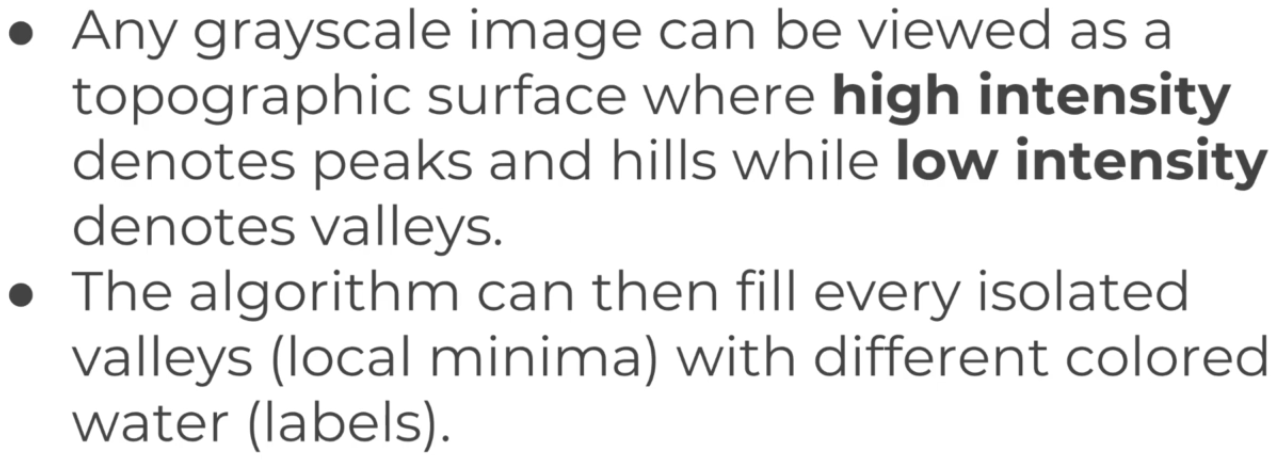

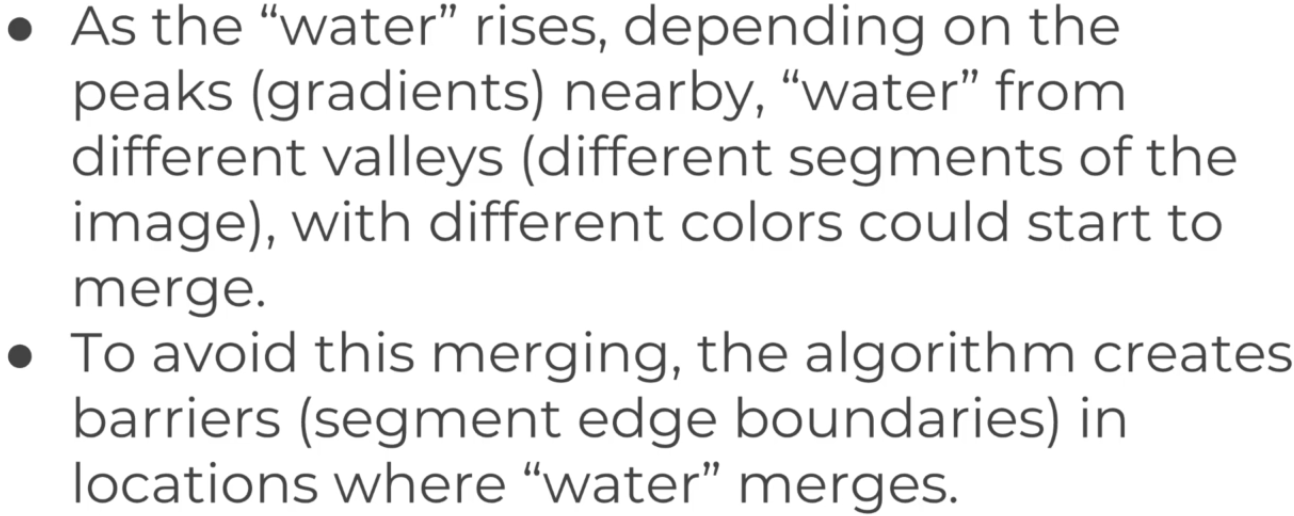

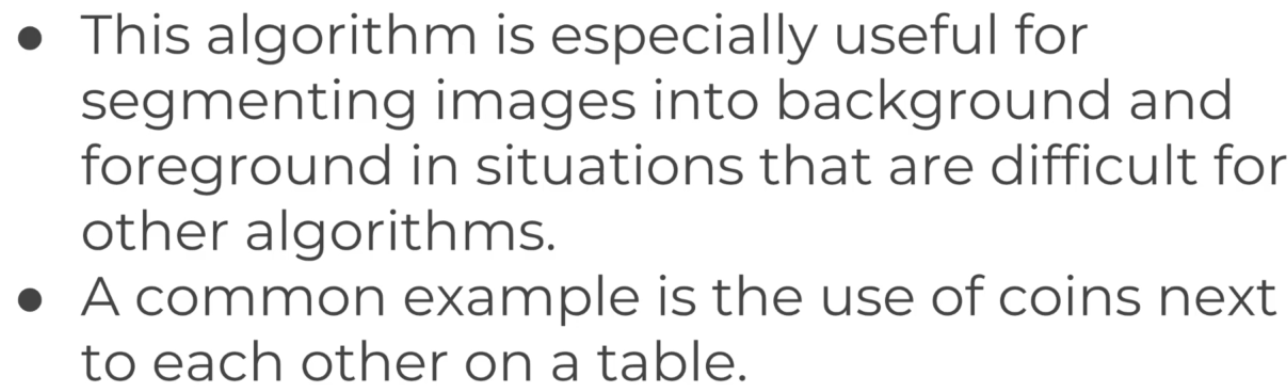

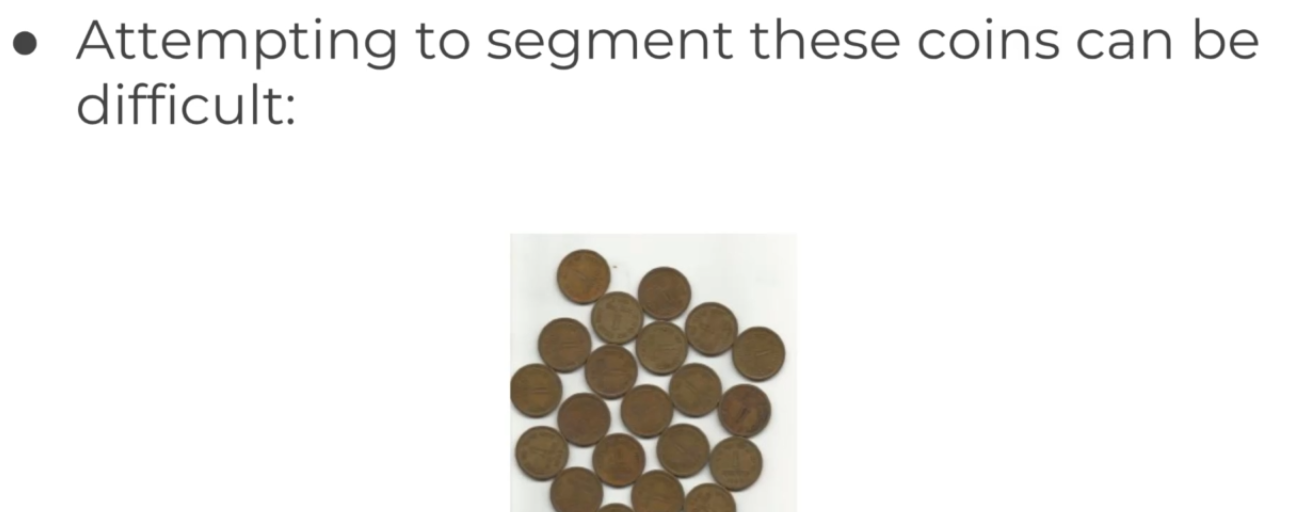
* For a human eye we can see that the image is having mulitple coins separated on a table.
* For computer vision algorithm its just a dark blob on the background of white.

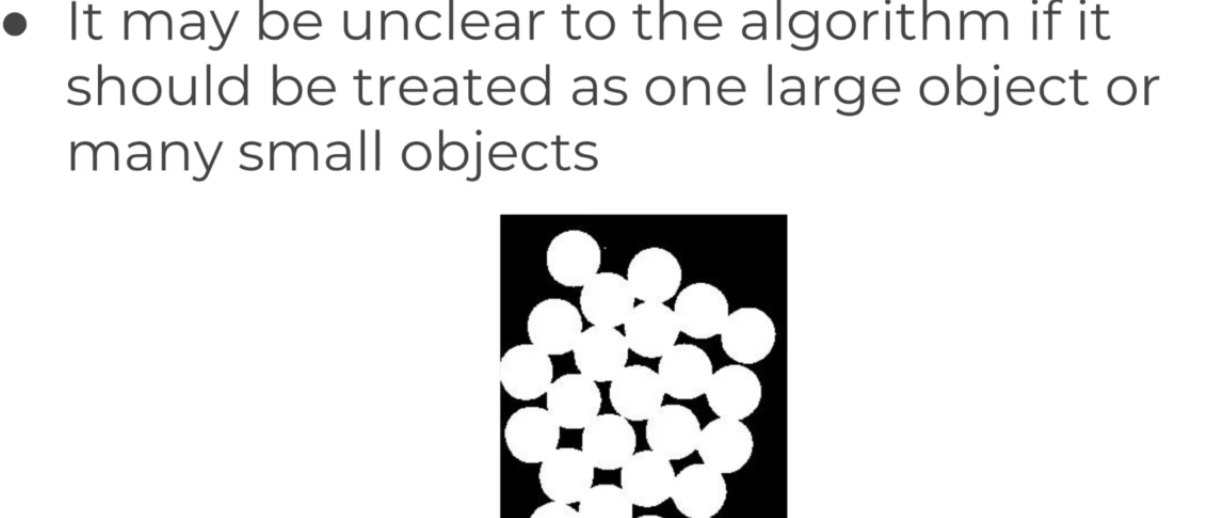

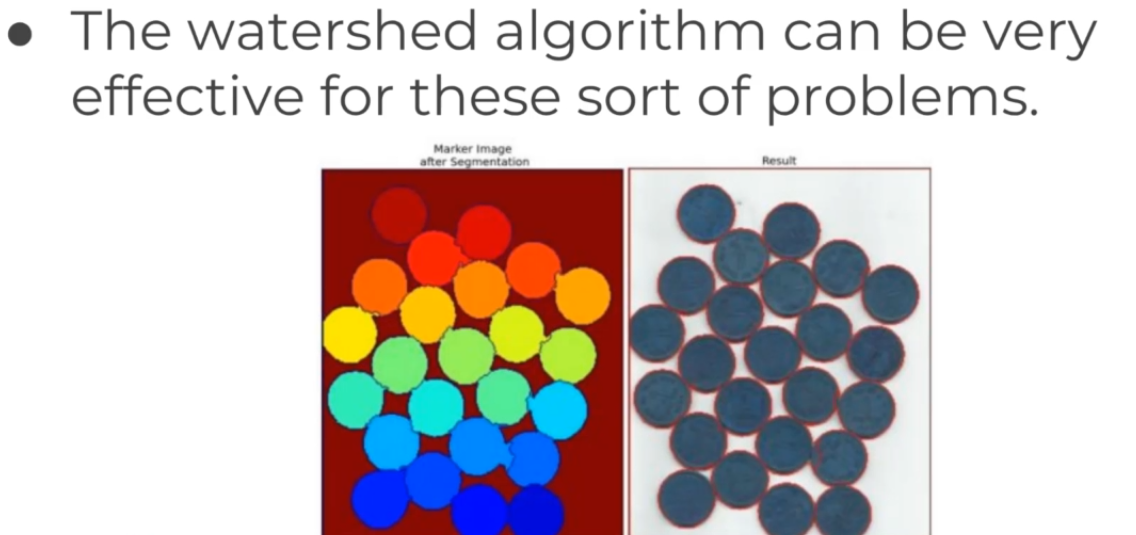
* The watershed algorithm helps in these type of cases by detecting the actual boundaries of these different segments, so that we can isolate and segment these coins individually as a human would.

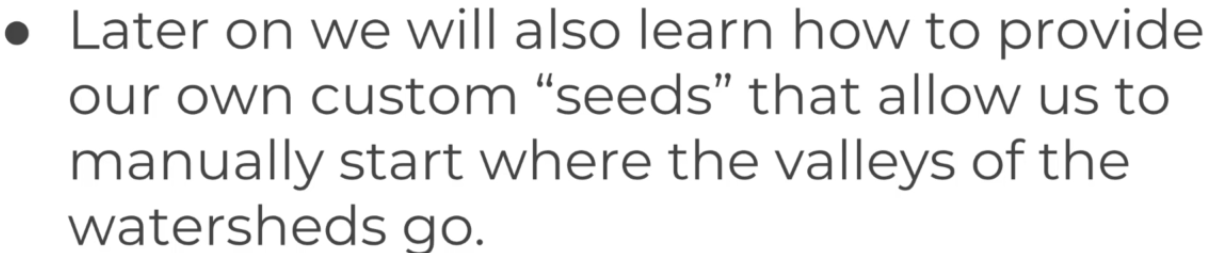
* We will be able to highlight sky on an image 

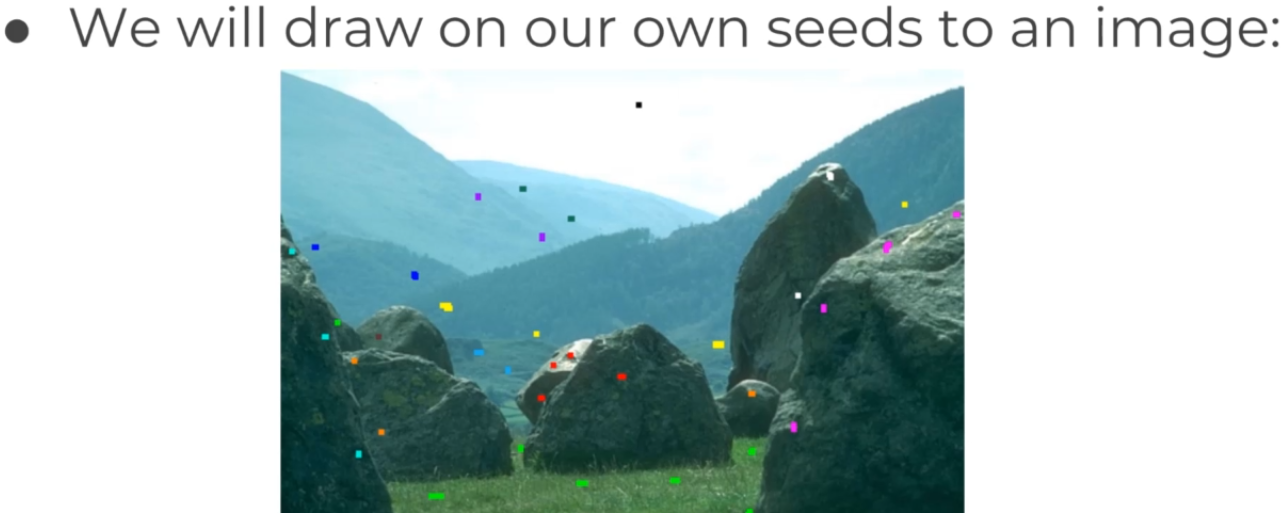

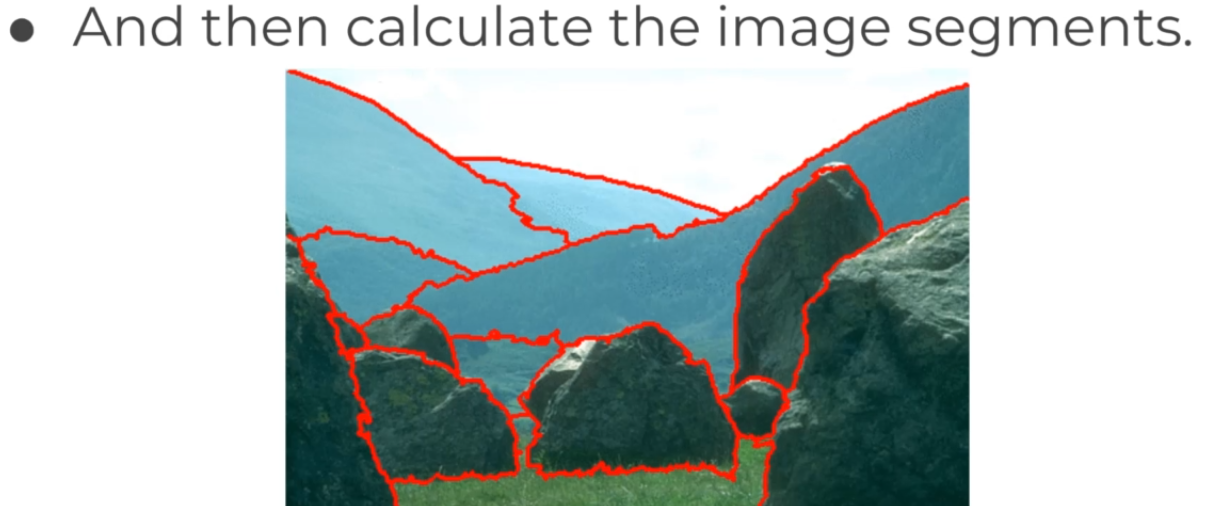

In [257]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [258]:
def disp(img,cmap = 'gray'):
    fig = plt.figure(figsize = (8,10))
    fig = fig.add_subplot(111)
    fig.imshow(img,cmap = 'gray')

In [259]:
coin = cv.imread('../Data/pennies.jpg',0)

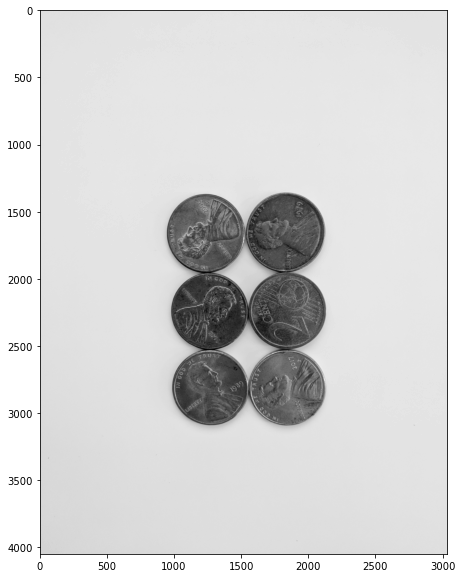

In [260]:
disp(coin)

* First lets try and apply the techniques we know and detect edges of coins.
* We will apply:
    * MedianBlur
    * Binary Threshold
    * Contours

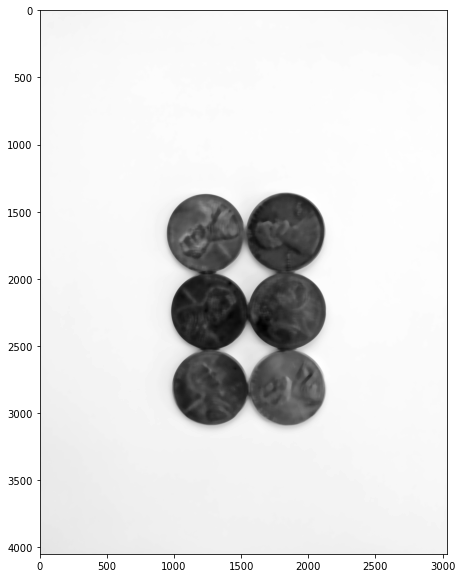

In [261]:
mbcoin = cv.medianBlur(coin,31)
disp(mbcoin)

* We can see that even thresholding is not able to separate the coins no matter how many different values we try we wont get a good result

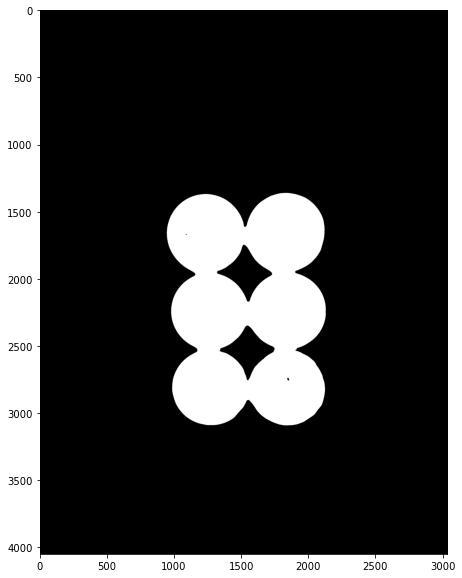

In [262]:
ret,dst = cv.threshold(mbcoin,150,255,cv.THRESH_BINARY_INV)
disp(dst)

In [263]:
cor,hie = cv.findContours(dst,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)

In [264]:
for i in range(len(cor)):
    
    if hie[0][i][3] == -1:
        cv.drawContours(coin,cor,i,(0,0,255),30)

* We can see that the algorithm is able to find one giant contour.
* It was not able to close the gaps between coins.

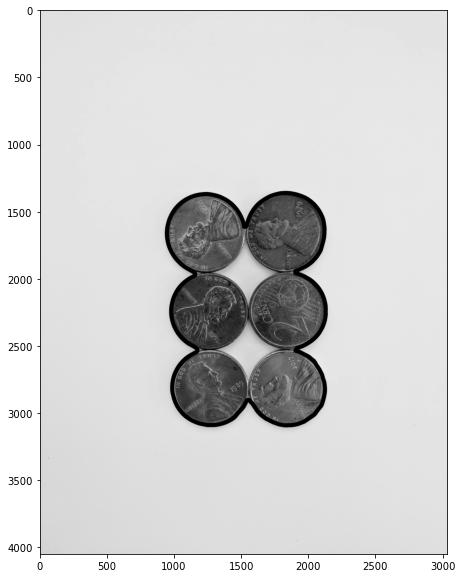

In [265]:
disp(coin)

# <center>WaterShed Alogrithm<center/>
* Lets use watershed algo and find six different pennies.

In [330]:
coin = cv.imread('../Data/pennies.jpg')

* First we apply blur.
* Its a suggestion to apply strong blur.

In [331]:
bcoin = cv.medianBlur(coin,37)

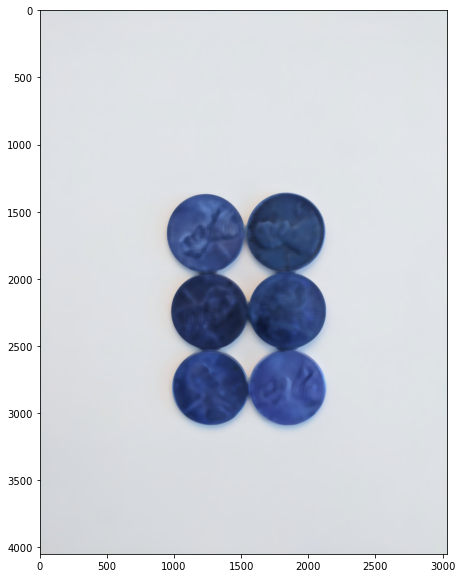

In [332]:
disp(bcoin)

* Know conver the img to grayscale.

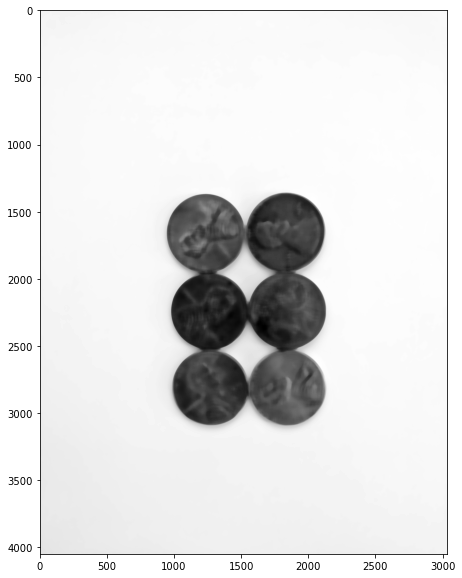

In [333]:
gbcoin = cv.cvtColor(bcoin,cv.COLOR_BGR2GRAY)
disp(gbcoin)

* We then apply threshold.

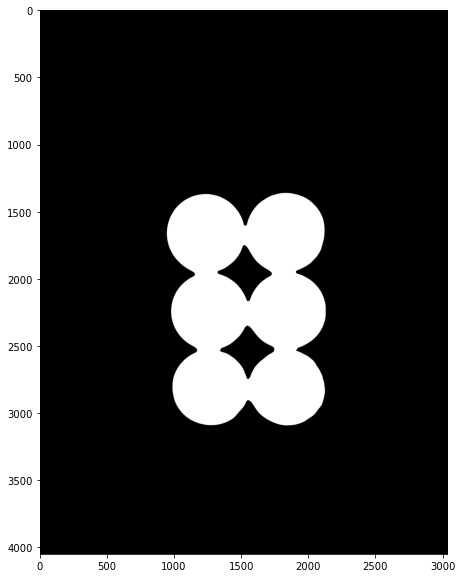

In [334]:
ret,tgbcoin = cv.threshold(gbcoin,150,255,cv.THRESH_BINARY_INV)
disp(tgbcoin)

* Then we apply noise reduction technique.
* This is not necessary step just a good practice after apply threshold.

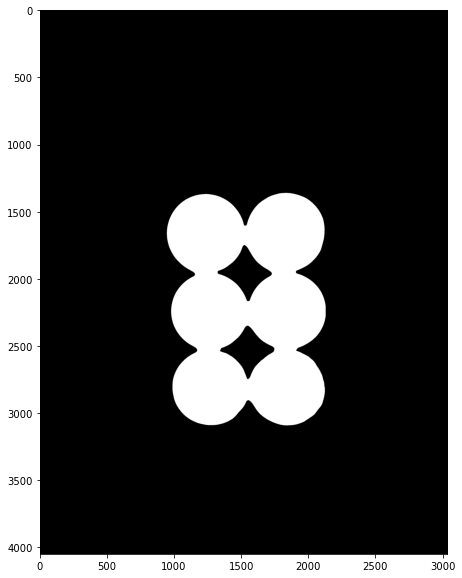

In [335]:
krnl = np.ones((5,5))
ready = cv.morphologyEx(tgbcoin,cv.MORPH_OPEN,krnl,iterations = 3)
disp(ready)

* Then we find background we are sure of.

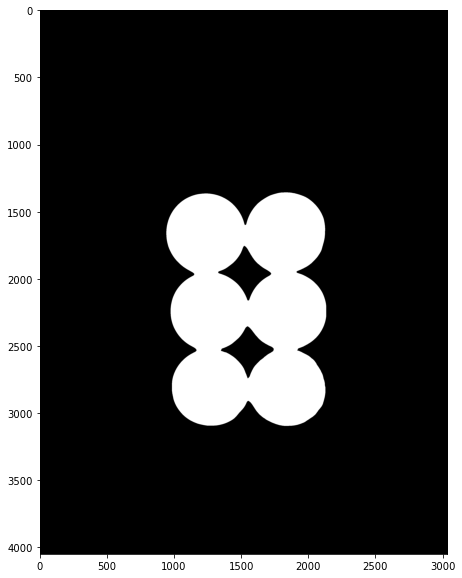

In [336]:
sure_bg = cv.dilate(ready,krnl,iterations = 2)
disp(sure_bg)

* In watershed algo. we set seeds that we are sure in the foreground.
* For this case we need 6 seed values for 6 coins.
* One seed for each of the center of the coin.
* For seed value we use distance transformation.
* In distance transformation the pixels that are further away from 0 their value ends up getting higher.
* Resource for Distance Transformation: https://en.wikipedia.org/wiki/Distance_transform
* https://homepages.inf.ed.ac.uk/rbf/HIPR2/distance.htm
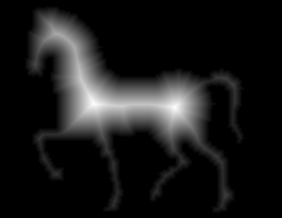

# cv::distanceTransform
$$	cv.distanceTransform(	src, distanceType, maskSize[, dst[, dstType]]	) ->	dst$$

* **src** :	8-bit, single-channel (binary) source image.
* **dst** :	Output image with calculated distances. It is a 8-bit or 32-bit floating-point, single-channel image of the same size as src.
* **labels** :	Output 2D array of labels (the discrete Voronoi diagram). It has the type CV_32SC1 and the same size as src.
* **distanceType** :	Type of distance, see DistanceTypes
* **maskSize** :	Size of the distance transform mask, see DistanceTransformMasks. DIST_MASK_PRECISE is not supported by this variant. In case of the DIST_L1 or DIST_C distance type, the parameter is forced to 3 because a 3×3 mask gives the same result as 5×5 or any larger aperture.

In [337]:
dsttrfm = cv.distanceTransform(ready,cv.DIST_L2,5) # default values

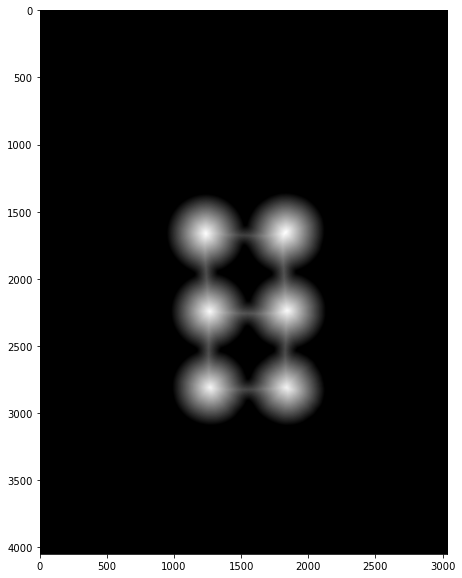

In [338]:
disp(dsttrfm)

* Now we find the sure foreground.

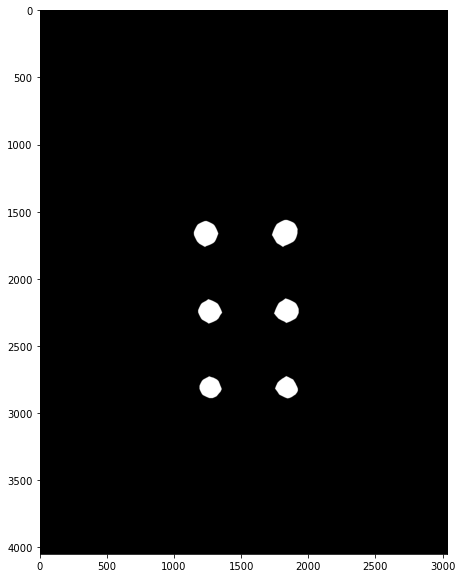

In [339]:
ret,sure_fg = cv.threshold(dsttrfm,0.7*dsttrfm.max(),255,0)
disp(sure_fg)

In [340]:
sure_bg.dtype , sure_fg.dtype

(dtype('uint8'), dtype('float32'))

In [341]:
sure_fg = np.uint8(sure_fg) 

* Now we find the in between section i.e the unknown region.

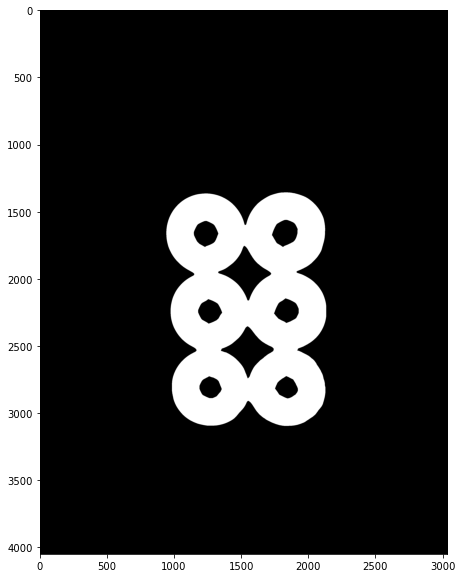

In [342]:
unknown = cv.subtract(sure_bg,sure_fg)
disp(unknown)

* Now we create label markers for watershed algorithm using sure_fg

In [343]:
ret,marker = cv.connectedComponents(sure_fg)
marker # there contain zeros of the shape sure_fg

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [344]:
np.unique(marker)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

<center>we are adding 1 so that values become 1 and we later will mark the region with black i.e 0

In [345]:
marker = marker + 1  
np.unique(marker)

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [346]:
# setting value to 0 where unknown img is having white pixels.
marker[unknown == 255] = 0 

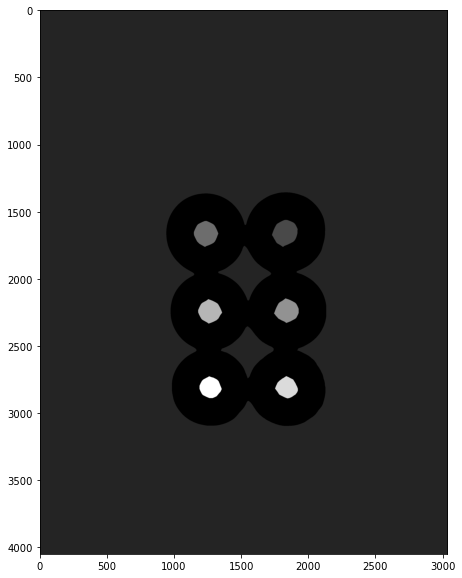

In [347]:
disp(marker)

#  cv::watershed
$$	cv.watershed(	image, markers	) ->	markers$$
* **image** :	Input 8-bit 3-channel image.
* **markers** :	Input/output 32-bit single-channel image (map) of markers. It should have the same size as image .


In [348]:
final = cv.watershed(coin,marker)

* Now we have perfectly segmented coin image.

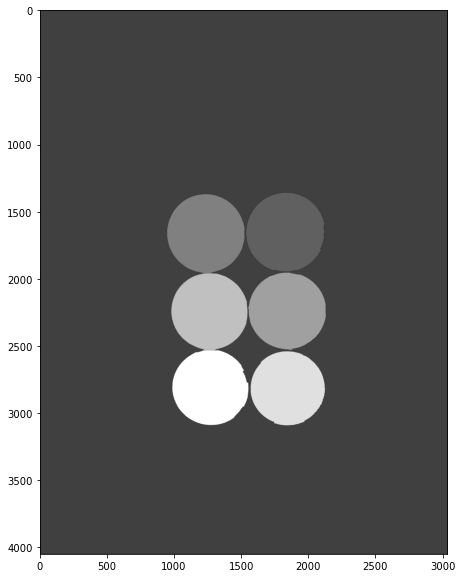

In [349]:
disp(final)

* We can also create contours and apply on the original image.

In [350]:
cor,hie = cv.findContours(final,cv.RETR_CCOMP,cv.CHAIN_APPROX_SIMPLE)
for i in range(len(cor)):
    
    if hie[0][i][3] == -1:
        cv.drawContours(coin,cor,i,(0,0,255),10)

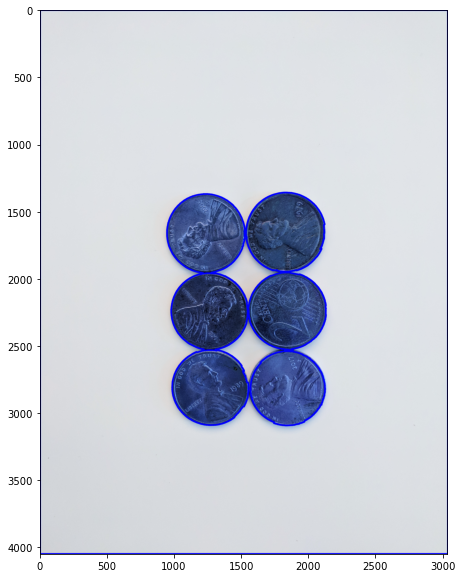

In [351]:
disp(coin)